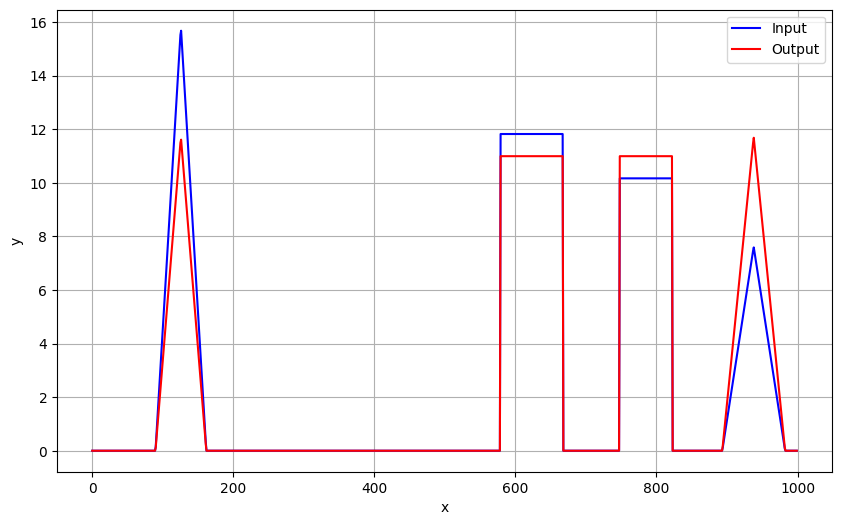

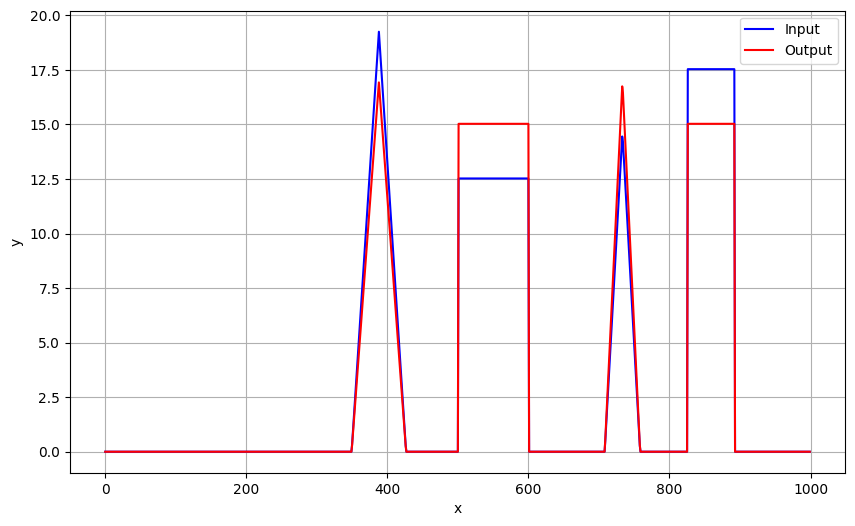

In [1]:
import shapes1d_dataset_generator as ShapeGen
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

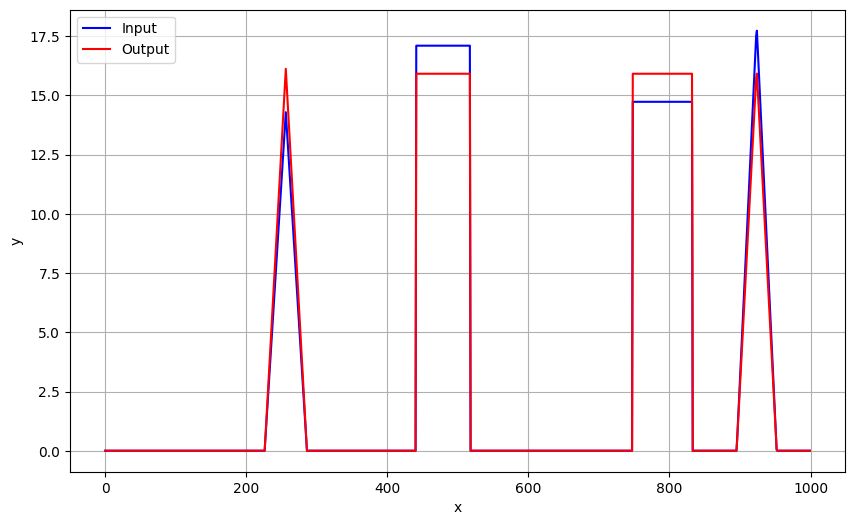

In [2]:
gen = ShapeGen.GeneratorShapes(10)
x0, y0, x, y, = gen.generate()
ShapeGen.plot_shapes(y0,y)

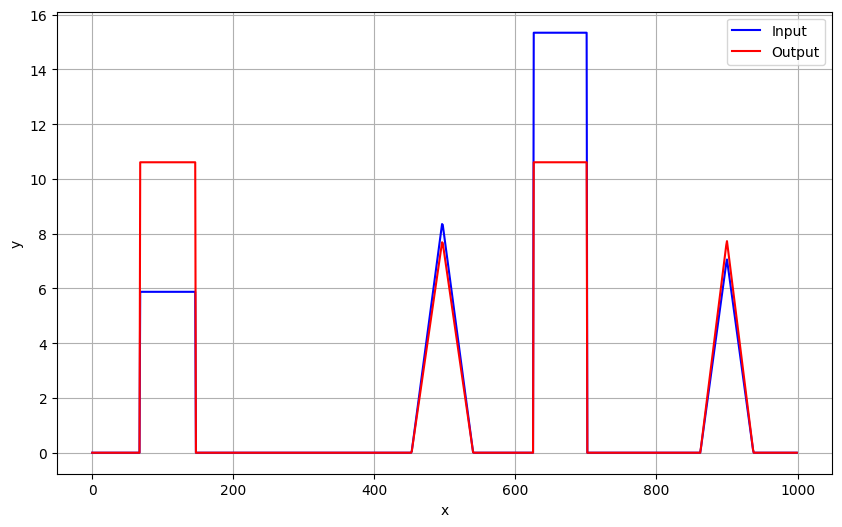

In [3]:
training_data = ShapeGen.Shapes1dDataset(10000,10)
training_loader = DataLoader(training_data, batch_size=32, shuffle=True)

_x, _y = next(iter(training_loader))
ShapeGen.plot_shapes(_x[0],_y[0])